### Использовать 1 из алгоритмов планирования для передвижения робототехнического агента из точки А в точку В (выбран алгоритм RRT)

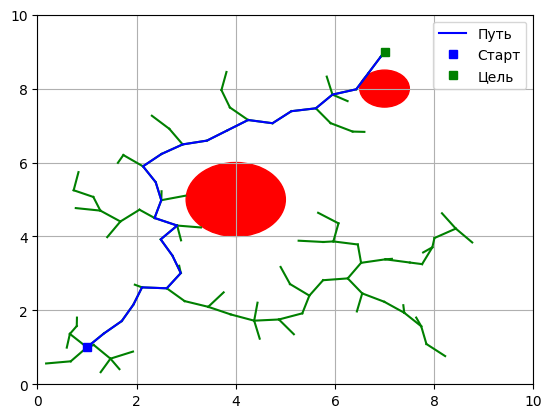

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Класс узла для дерева RRT
class Node:
    def __init__(self, position):
        self.position = position  # позиция узла
        self.parent = None        # ссылка на родительский узел
        
# Функция для расчета евклидова расстояния между двумя узлами
def distance(node1, node2):
    return np.linalg.norm(np.array(node1.position) - np.array(node2.position))
    
# Функция "стягивания" (steer) - перемещает ближайший узел к случайной точке, но ограничивает шаг
def steer(from_node, to_position, max_step=0.5):
    # Ограничение шага перемещения, если расстояние больше максимального
    direction = np.array(to_position) - np.array(from_node.position)
    dist = np.linalg.norm(direction)
    if dist > max_step:
        direction = direction / dist * max_step
    new_position = np.array(from_node.position) + direction
    return Node(tuple(new_position))
    
# Функция для генерации случайной позиции внутри области
def random_position(bounds):
    return (np.random.uniform(bounds[0][0], bounds[0][1]),
            np.random.uniform(bounds[1][0], bounds[1][1]))
    
def is_in_obstacle(position, obstacles):
    # Проверка, находится ли позиция внутри одного из препятствий
    for (ox, oy, radius) in obstacles:
        if np.linalg.norm(np.array(position) - np.array((ox, oy))) <= radius:
            return True
    return False
    
# Функция для поиска ближайшего узла в дереве по отношению к заданной позиции
def nearest_node(tree, position):
    return min(tree, key=lambda node: distance(node, Node(position)))
    
# Алгоритм RRT
def rrt(start, goal, bounds, obstacles, max_iter=1000, max_step=0.5, goal_sample_rate=0.1):
    tree = [Node(start)]
    goal_node = Node(goal)

    for i in range(max_iter):
        # Случайная выборка: с вероятностью goal_sample_rate выбираем целевую точку вместо случайной
        if np.random.rand() < goal_sample_rate:
            random_position_ = goal
        else:
            random_position_ = random_position(bounds)

        nearest = nearest_node(tree, random_position_) # Находим ближайший узел в дереве к случайной позиции
        new_node = steer(nearest, random_position_, max_step) # Пытаемся сдвинуть ближайший узел в сторону случайной позиции, ограничивая длину шага

        # Если новая точка не попала в препятствие, добавляем её в дерево
        if not is_in_obstacle(new_node.position, obstacles):
            new_node.parent = nearest
            tree.append(new_node)

            # Если достигли цели, заканчиваем
            if distance(new_node, goal_node) < max_step:
                goal_node.parent = new_node
                tree.append(goal_node)
                return tree, goal_node

    return tree, None  # если не удалось достичь цели
    
def reconstruct_path(goal_node):
    # Восстановление пути из дерева
    path = []
    node = goal_node
    while node is not None:
        path.append(node.position)
        node = node.parent
    return path[::-1]

# Визуализация результата
def plot_rrt(tree, path, start, goal, obstacles, bounds):
    fig, ax = plt.subplots()
    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])

    for node in tree:
        if node.parent is not None:
            ax.plot([node.position[0], node.parent.position[0]],
                    [node.position[1], node.parent.position[1]], "-g")

    for (ox, oy, radius) in obstacles:
        circle = plt.Circle((ox, oy), radius, color='r')
        ax.add_patch(circle)

    if path:
        ax.plot([pos[0] for pos in path], [pos[1] for pos in path], '-b', label="Путь")

    ax.plot(start[0], start[1], "bs", label="Старт")
    ax.plot(goal[0], goal[1], "gs", label="Цель")
    ax.legend()
    plt.grid(True)
    plt.show()

# Использование
start = (1, 1)
goal = (7, 9)
bounds = [(0, 10), (0, 10)]  # границы области
obstacles = [(4, 5, 1), (7, 8, 0.5)]  # препятствия (x, y, радиус)

# Запуск RRT
tree, goal_node = rrt(start, goal, bounds, obstacles, max_iter=500)

# Восстановление пути и визуализация
if goal_node:
    path = reconstruct_path(goal_node)
    plot_rrt(tree, path, start, goal, obstacles, bounds)
else:
    print("Не удалось найти путь")
